# Data Cleaning and PreProcessing

## 1. Load Raw Data

In [3]:
import pandas as pd

# Load datasets
traffic_df = pd.read_csv(r"D:\Menternship Project\traffic_data.csv")
#traffic_df.columns

## 2. Clean Data

#### 2.1 Handle Missing Values

In [6]:
# Check missing values
print(traffic_df.isnull().sum())

# Impute missing values or drop rows/columns
traffic_df = traffic_df.fillna(method='ffill')  # forward fill as example
# traffic_df = traffic_df.dropna()  # OR drop if necessary
#traffic_df.columns

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


C:\Users\sushmas\AppData\Local\Temp\ipykernel_9720\3593157735.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  traffic_df = traffic_df.fillna(method='ffill')  # forward fill as example


#### 2.2 Remove Duplicates

In [8]:
traffic_df = traffic_df.drop_duplicates()
#traffic_df.columns

#### 2.3 Correct Data Types

In [10]:
# Convert datetime column
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

# Ensure numeric types for counts
traffic_df['Vehicles'] = traffic_df['Vehicles'].astype(int)


C:\Users\sushmas\AppData\Local\Temp\ipykernel_9720\1328541355.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])


## 3. Aggregate Traffic Data to Hourly Intervals


In [12]:
# Set datetime as index
traffic_df.set_index('DateTime', inplace=True)

# Group by hour and junction
hourly_traffic = traffic_df.groupby([pd.Grouper(freq='H'), 'Junction'])['Vehicles'].sum().reset_index()

# Rename for clarity
hourly_traffic.rename(columns={'Vehicles': 'hourly_vehicle_count'}, inplace=True)


C:\Users\sushmas\AppData\Local\Temp\ipykernel_9720\1328341785.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_traffic = traffic_df.groupby([pd.Grouper(freq='H'), 'Junction'])['Vehicles'].sum().reset_index()


## 4. Normalize or Standardize the Data


In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Example: using MinMaxScaler
scaler = MinMaxScaler()
hourly_traffic[['hourly_vehicle_count']] = scaler.fit_transform(hourly_traffic[['hourly_vehicle_count']])


## 5. Feature Engineering and Selection

#### 5.1 Create New Features from Raw Data


#### a. Time-Based Features


In [18]:
# Extract time-based features
traffic_df.reset_index(inplace=True)
#traffic_df.info()
# Convert DateTime to datetime object
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format="%d/%m/%y %I:%M %p")

# Rename columns for easier use
traffic_df.rename(columns={'DateTime': 'timestamp', 'Junction': 'junction_id', 'Vehicles': 'vehicle_count'}, inplace=True)

traffic_df['hour'] = traffic_df['timestamp'].dt.hour
traffic_df['day_of_week'] = traffic_df['timestamp'].dt.dayofweek  # Monday=0
traffic_df['month'] = traffic_df['timestamp'].dt.month


#### b. Lag Features (Temporal Dependencies)


In [20]:
# Sort to ensure correct order for lagging
traffic_df = traffic_df.sort_values(by=['junction_id', 'timestamp'])

# Create lag features
traffic_df['lag_1h'] = traffic_df.groupby('junction_id')['vehicle_count'].shift(1)
traffic_df['lag_24h'] = traffic_df.groupby('junction_id')['vehicle_count'].shift(24)
traffic_df['lag_168h'] = traffic_df.groupby('junction_id')['vehicle_count'].shift(168)


# Binary indicator for weekend
traffic_df['is_weekend'] = traffic_df['day_of_week'].isin([5, 6]).astype(int)

# Drop rows with NaN lag values
model_df = traffic_df.dropna(subset=['lag_1h', 'lag_24h', 'lag_168h'])

# Feature list
features = ['hour', 'day_of_week', 'month', 'lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']
target = 'vehicle_count'



## 6. Evaluate Feature Importance


#### a. Correlation Matrix (Statistical Insight)


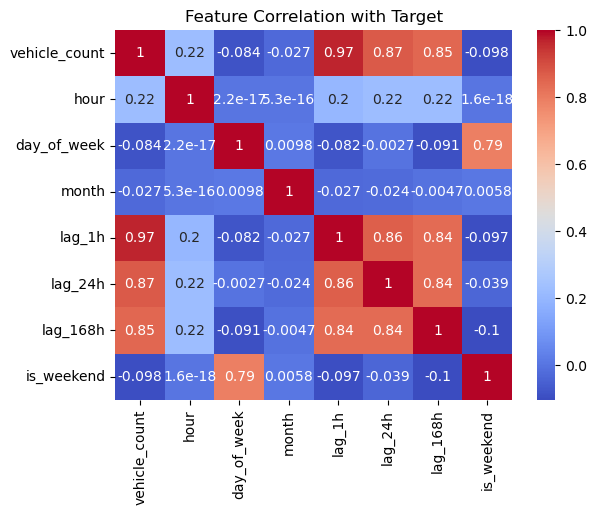

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features
corr_cols = ['vehicle_count', 'hour', 'day_of_week', 'month',
             'lag_1h', 'lag_24h', 'lag_168h', 'is_weekend']

# Drop rows with NaNs (from lags)
corr_df = traffic_df[corr_cols].dropna()

# Compute and plot
corr = corr_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()


#### b. Tree-Based Feature Importance (Model-Driven Insight)


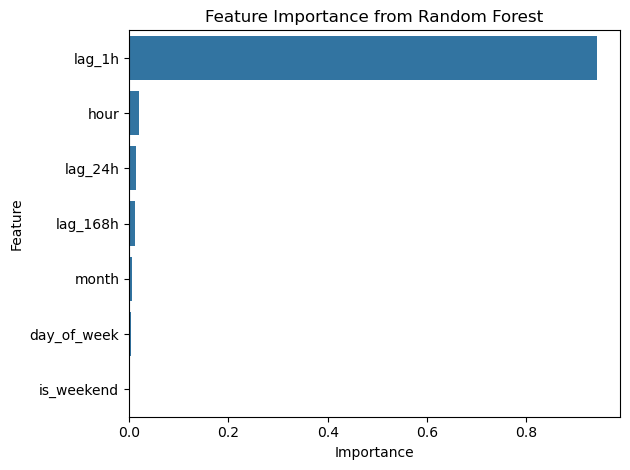

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare training data
X = model_df[features]
y = model_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit RandomForest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance plot
importances = rf.feature_importances_
imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()


## 7. Select Most Important Features


In [27]:
# Select top N features
top_features = imp_df['Feature'].head(5).tolist()
print("Selected Features for Modeling:", top_features)


Selected Features for Modeling: ['lag_1h', 'hour', 'lag_24h', 'lag_168h', 'month']


In [28]:
traffic_df.to_csv("traffic_features.csv", index=False)
print("Script executed successfully. Engineered dataset saved as 'traffic_features.csv'.")


Script executed successfully. Engineered dataset saved as 'traffic_features.csv'.
